# Bayesian A/B Testing

## Introduction

### A/B Testing

A/B Testing is used to compare several items and select the best option based on a quantitative metric. 

Some applications include:

+ Testing a new medicine to see if it works. We test if it works by having a control group vs treatment group.
+ Designing several options for a website to see which one brings the most conversion rate.
+ Comparing the ratio of failures of hardware from two vendors.

### Frequentist vs Bayesian approach

Frequentist approach:
+ Frequentist assume there is a **true value** for a given population parameter. 
+ Inference exists to estimate it to a given level of confidence: $\hat{\theta} = \text{argmax}_\theta P(X | \theta)$.

Bayesian approach:
+ Bayesian assume the given population parameter is a **random variable**. 
+ Inference exits to calculate its **posterior probability distribution** from the data we have collected: $P(\theta | X)$.

Sampling methods:
+ Importance sampling
+ Markov chain Monte Carlo ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)), typically used to approximate large multi-dimensional integrals

___

## Limits of Frequentist Statistics

### General limitations

+ Terms and definitions are hard to understand for non-technical - and even many technical - people.
+ The experiment needs to run for the appropriate sample size before we can draw conclusions without running the risk of false positives.
+ Failing to reject the null hypothesis is NOT the same as accepting it. Maybe the sample size was just to small or the variance very large.

### Estimating a population parameter

We use the CLT to estimate the value of a population paramater to a given level of confidence. The variance of the sampling distribution of the sample statistic is a Gaussian Distribution of variance $\sigma^2 / N$, where $\sigma^2$ is the variance of the population paramater.

Drawbacks:
+ if $\sigma$ is large, you need large samples to get an accurate view
+ we usually don't know $\sigma$, but we can use the sample variance $\hat{\sigma}$ instead (or use the t-distribution for more precise CI)

### Limits of p-value

The example below shows the evolution of the p-value of Chi-Square tests comparing two ads over time. We see that the p-value can vary dramatically from one experiment to the next:

In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

class Clickthrough:
    
    def __init__(self, ctr_a, ctr_b, n_visits):
        '''
        init the true ctr of two ad campaigns
        and the empty df that will store the observed ctr
        and the p-value of the chi-square test after each visit
        '''
        self.ctr_a = ctr_a
        self.ctr_b = ctr_b
        self.visits = 0
        self.visits_a = np.array([0, 0])
        self.visits_b = np.array([0, 0])
        self.pval = np.zeros(n_visits)

    def visit(self):
        '''
        simulates a visit that have a self.true_ctr likelihood
        of doing a ctr
        '''
        # random visit result
        self.visits += 1
        click_a = (np.random.random() < self.ctr_a)
        click_b = (np.random.random() < self.ctr_b)
        
        # save results
        self.visits_a += [click_a, 1 - click_a]
        self.visits_b += [click_b, 1 - click_b]
        
        # calculate p-value of chi-square test
        self.calculate_pval()
      
    def calculate_pval(self):
        '''
        calculate the p-value of a chi-square test checking if ad_A and ad_B have 
        the same ctr
        '''
        if self.visits > 10:
            _, pval, _, _ = chi2_contingency(np.array([self.visits_a, self.visits_b]), correction=False)
            self.pval[self.visits - 1] = pval
        
    def display_results(self):
        '''
        display the respective clicks of ad_A and ad_B in a nice way
        '''
        df = pd.DataFrame(
            np.array([self.visits_a, self.visits_b]), 
            index=['ad_A', 'ad_B'],
            columns=['Click', 'No Click']
        )
        return df
    
    def plot_pvalues(self):
        plt.plot(self.pval)
        plt.plot(np.ones(self.pval.shape[0]) * 0.05)
        axes = plt.gca()
        axes.set_ylim([0,1])
        plt.show()

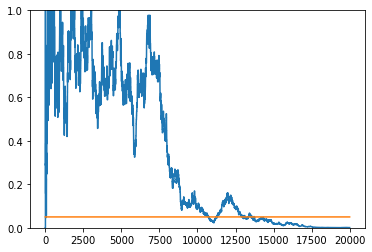

In [196]:
n_visits = 20000
ctr = Clickthrough(0.1, 0.11, 20000)
for visits in range(20000):
    ctr.visit()
    
ctr.plot_pvalues()

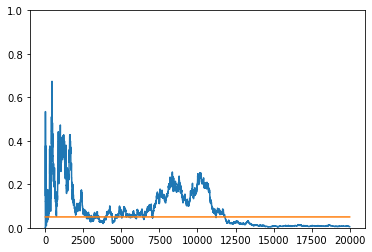

In [197]:
n_visits = 20000
ctr = Clickthrough(0.1, 0.11, 20000)
for visits in range(20000):
    ctr.visit()
    
ctr.plot_pvalues()

___

## Probability & Bayes Theorem

### Definitions

Probability is the likelihood of a given event occuring for each experiment of a given sample space.

Draw $r$ times from a population of $n$ (with or without repetition):
+ Permutations: order matters
+ Combination: order does not matter

<br>

Relationship between events:
+ **Marginal** probability: P(A)
+ **Conditional** probability P(B|A): probability of B given A
+ **Joint** probability P(A ∩ B): Intersection of two events A and B 
+ Union of two events P(A ∪ B): A or B
+ Complement of an event P(A'): not A

Note: 
+ rule of substraction: P(A) = 1 - P(A')
+ rule of addition: P(A ∪ B) = P(A) + P(B) - P(A ∩ B)
+ rule of multiplication: P(A ∩ B) = P(A) P(B|A)
+ rule of multiplication: P(A ∩ B ∩ C) = P(A) P(B|A) P(C|AB)

<br>

Events are:
+ Independant when the outcome of one has no effect on others
+ Dependant when the outcome of one has some effect on others (example: draw without replacement)

Note for independant events: 
+ P(B|A) = P(B) so P(A ∩ B) = P(A) P(B)

### Bayes Theorem

We know that P(A ∩ B) = P(A) P(B|A) = P(B) P(A|B). It means that (Bayes Theorem):
+ P(A|B) = P(B|A) $\times$ P(A) / P(B)

Where:
+ P(B) = sum [ P(B|A) $\times$ P(A) ] for all A _(or integral for continuous data)_

Notes:
+ probabilities equal to one when considering the space of random variables. The sum of P(B|A) will be equal to one for each given value of A.
+ P(B) does not depend on A, so $\text{argmax}_A P(A|B) = \text{argmax}_A P(B|A) P(A)$

### Curse of Dimensionality

**Joint probabilities** increase **exponentially** with the number of variables:
+ requires more computational power
+ requires more data to get accurate estimates
+ leads to exponentially small probabilities (computers having finite precision lead to underflow issues)
+ log probability can be used to mitigate this issue

___

## Bayes Theorem Examples

### Diagnostic Tools

Bayes Theorem determines the probability of a parameter given a certain event. It is used extensively in fields with diagnostic tools that are only effective to a certain degree.

+ a company learns that 0.2% of their products are defective.
+ they buy a diagnotic tool that is correct 99% of the time.
+ if a part is diagnosed as defective, what is the probability that is is _really_ defective?

Let's use the following notations:
+ OK when not defective, NOK when defective
+ DI when diagnosed as not defective, NDI when diagnosed as defective

Bayes Theorem states that:

+ P(NOK|NDI) = P(NDI|NOK) P(NOK) / P(NDI)

Where:
+ P(NDI|NOK) = 0.99 - true positive
+ P(NOK) = 0.002
+ P(NDI) = P(NDI|NOK) x P(NOK) + P(NDI|OK) x P(OK) = true positive + false positive = 0.99 x 0.002 + 0.01 x 0.998

It means that:
+ P(NOK|NDI) = 16.5%

If we run a second test that is _also_ positive on the same product, we can update the probability of it being _really_ defective using the result of the first test:

+ P(NOK) = 16.5%
+ P(NOK|NDI) = 95.1%

### Coin tosses

We want to toss a fair coin 200 times. After 20 tosses, we have 15H and 5T. What is the expected end result?

+ it is not 100H and 100T, because we have already tossed 20 times.
+ it has become 15 + (200 - 20) / 2 = 105H and 5 + (200 - 20) / 2 = 95T.

### Monty Hall Problem

A show has three doors to choose from, and behind one of them is a car. After you choose one door, the host reveals another one and asks you if you want to switch. Should you do it?

Let's imagine you choose door N°1 and the host opens door at door you did not pick, for instance N°2. You want to calculate the probabilities of P(D1 | H2) and P(D3 | H2), where P(Dx) is the probability that the car is behind door N°x and H2 the door that the host has chosen.

+ P(Dx | H2) = P(H2 | Dx) * P(Dx) / P(H2)
+ P(H2) = P(H2 | D1) * P(D1) + P(H2 | D2) * P(D2) + P(H2 | D3) * P(D3) 

Let's look at P(H2 | Dx):
+ P(H2 | D1) = 0.5   - the host could have chosen either door N°2 or door N°3
+ P(H2 | D2) = 0     - the host would not reveal the car
+ P(H2 | D3) = 1     - the host would always avoid revealing the door that the contestant chose if possible

A simple calculation gives P(D1 | H2) = 1/3 and P(D3 | H2) = 2/3: you should switch doors.

___

## Bayesian Statistics

The bayesian approach treats $\theta$ as a random variable.

+ $P(\theta | X) = P(X | \theta) \times P(\theta) / P(X)$
+ $P(X)$ does not depend on $\theta$. It's called the **normalizing constant** $Z$.
+ $P(\theta)$ is called the **prior**: the old belief about $\theta$
+ $P(X | \theta)$ is called the **likelihood**: how likely is the data we have collected given the current $\theta$
+ $P(\theta | X)$ is called the **posterior**: the new belief about $\theta$ after seeing the data.

_Note: $P(X)$ is the integral over $P(X | \theta) P(\theta) d\theta$ and is impossible to solve without sampling methods like MCMC_.

### Conjugate Priors

If we choose specific distributions for $P(X | \theta)$ and $P(\theta)$, called **[conjugate priors](https://en.wikipedia.org/wiki/Conjugate_prior)**, we can make the posterior $P(\theta | X)$ follow the same type of distribution as the prior $P(\theta)$.

For instance, if $P(X | \theta)$ is Bernoulli, then $\theta$ follows a distribution going from 0 to 1. Its PDF can be modelled by $P(\theta) = Beta(a, b)$. Combining both Bernoulli likelihood function and $\theta$ distribution, we can show that $P(\theta | X)$ follows a Beta distribution:

+ $P(\theta | X) = Beta(a', b')$
+ $a' = a + \text{count of successes}$, $b' = b + \text{count of failures}$.

We can choose the original values $a = b = 1$: this amounts to chooses a **non-informative prior** $P(\theta) = Beta(1, 1) = \text{Uniform(0, 1)}$. As the sample size increases, the influence of prior becomes negligible.

_Note: $E(Beta(a, b) = \frac{a}{a+b}$; its variance decreases as a and b get bigger._

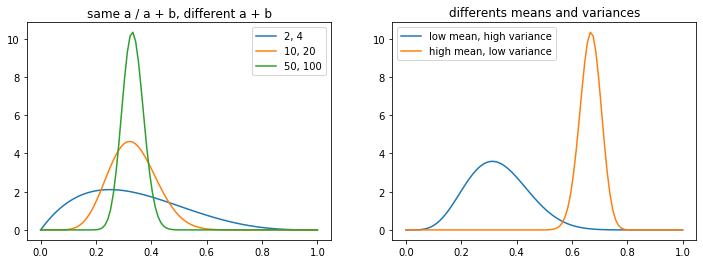

In [388]:
# examples of beta pdf
import numpy as np
from matplotlib import pyplot as plt 
from scipy.stats import beta

x = np.linspace(0, 1, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))

ax1.set_title("same a / a + b, different a + b")
ax1.plot(x, beta.pdf(x, 2, 4), label='2, 4')
ax1.plot(x, beta.pdf(x, 10, 20), label='10, 20')
ax1.plot(x, beta.pdf(x, 50, 100), label='50, 100')
ax1.legend(loc='upper right')

ax2.set_title("differents means and variances")
ax2.plot(x, beta.pdf(x, 6, 12), label='low mean, high variance')
ax2.plot(x, beta.pdf(x, 100, 50), label='high mean, low variance')
ax2.legend(loc='upper left')

Note: We can compare the probability of two independent events $\mu_1$ and $\mu_2$. 

For $\mu_1 > \mu_2$, it is the area under the joint PDF $p(\mu_1 \cap \mu_2) = p(\mu_1) \times p(\mu_2)$ where $\mu_1 > \mu_2$. 

This lets us stop the experiment when the expected value of the loss function $max(\mu_2 - \mu_1, 0)$ is smaller than a given threshold.

___

## A/B Testing

### Explore vs Exploit

The Multi-Armed Bandits states that you are in a casino playing slots. Three machines have three different pay rates: 30%, 20%, and 10% respectively.

Frequentist Statistics would:
+ perform a Chi-Square test after $N$ trials
+ calculate the p-value
+ identify if one of them is significantly better than the others

But if you were to test it, you would:
+ try each machine a few times
+ collect data
+ adapt your strategy to your conclusions

A typical strategy would be to:
+ **explore** at random to collect more data, 
+ or **exploit** the one that seems to give the best results

### Epsilon-Greedy Algorithm

The goal is to adapt the A/B testing over time: show the ad performing better more often.

+ **explore** with probability **epsilon**: show random ad
+ **exploit** otherwise: show best ad

This algorithm has some limitations:
+ it still shows underperforming ads
+ the probability of showing the best option is $\epsilon \times 1/ads + (1 - \epsilon) = 1 - \epsilon \times (1 - 1/ads)$
+ in other words, the loss is proportional to $N$

### UCB1 - Upper Confidence Bound

We use another way of building confidence intervals: Chernoff-Hoeffding bounds. 

+ CLT: $P(\mu \in \left[\hat{\mu} \pm F(N)\right]) = 0.95$
+ Chernoff-Hoeffding: $P(\mu \in \left[\hat{\mu} \pm \epsilon\right]) > F(N, \epsilon)$

We can use this confidence interval to bound the true pay rates of each arm of the problem. We can maximize the likelihood of winning by using the upper bound of each mean $\mu_j + \epsilon_j$: 

$$\epsilon_j = \sqrt{\frac{2 \ln(N)}{N_j}}$$

The UCB1 calculates the upper value of each mean, then shows the ad with the highest number:
+ **explore** ads that have not been shown much (low $N_j$ compared to $N$)
+ **exploit** ads with high mean

Notes:
+ $\epsilon_j$ converges to zero when $N$ becomes very large
+ the loss is proportional to $\ln(N)$

### Thompson Sampling

Assuming the likelihood is Bernoulli and the prior is Beta, we have shown that the posterior is also Beta.

We can draw random numbers from each Beta distribution: as the sample size increases, their mean will get closer to the actual parameter value and their variance will decrease. It means that:
+ the more confident we are, the closer from the actual parameter value the random number will be
+ the less confident we are, the more random this random number will be, ie. it will be more exploratory

Thompson sampling draws a random number from all current Beta distributions, then show the ad that drew the highest number.
+ **explore** ads with high variance
+ **exploit** ads with high mean and low variance

<br>

Remember the conjugate priors idea for Bernoulli distributions: a' and b' count the number of successes and failures that happened since we last updated the prior:

+ $P(\theta) = Beta(a, b)$
+ $P(\theta | X) = Beta(a', b')$
+ $a' = a + \text{count of successes}$, $b' = b + \text{count of failures}$.

We update a' and b' at each step, which means that we update a and b at every step: we leverage our posterior to udpate the new prior $P(\theta_{t+1})$.

+ $P(\theta_t) = Beta(a_t, b_t)$
+ $P(\theta_t | X_t) = Beta(a'_t, b'_t)$ where $a'_t = a_t + isSuccess$, $b'_t = b_t + isFailure$
+ $P(\theta_{t+1}) = Beta(a'_t, b'_t)$

### Implementation

In [567]:
import numpy as np
import random
import matplotlib.pyplot as plt

class MAB:
    '''
    Multi-Armed-Bandit problem
    '''
    
    def __init__(self, N=5000):
        '''
        Initialize class with:
        + fixed ads + theoritical CTR
        + index of best ad based on CTR
        + array to track ads served and CTR for each ad
        '''
        # ads
        self.ads = np.array([['A', 0.75],['B', 0.55],['C', 0.65]])
        self.ads_count = self.ads.shape[0]
        self.best_ad_idx = self.ads[:, 1].astype(float).argmax()

        # number of trials in the experiment
        self.N = N
        
        # ads served during the experiment
        (self.ads_served, self.clicks) = self.initialize_experiment(inplace=False)
        
        # snapshots of thompson betas - plotting
        self.x = np.linspace(0, 1, 100)
        self.thompson_betas = {}
        
        
    
    def initialize_experiment(self, inplace=True):
        '''
        resets self.ads_served to zero.
        inplace for more clarity in the init phase
        + ads_served[0]: total visits
        + ads_served[1]: total clicks
        + clicks: captures if click or no click at each visit
        '''
        # ads_served[0]: total visits
        # ads_served[1]: total clicks
        
        # we initialize the visits at one to handle the ucb1 algorithm
        ads_served = np.zeros((self.ads_count, 2))
        ads_served[:, 0] = 1
        
        clicks = np.zeros(self.N)
        if inplace:
            self.ads_served = ads_served
            self.clicks = clicks
        else:
            return (ads_served, clicks)
        
        
    def new_ad_served(self, n, selected_ad):
        '''
        adds a new count for the [selected_ad]
        plus a new result that follows its theoritical CTR
        '''
        self.ads_served[selected_ad][0] += 1
        
        is_click = np.random.random() < self.ads[selected_ad, 1].astype(float)
        self.clicks[n] = is_click
        if is_click:
            self.ads_served[selected_ad][1] += 1
        
        
    def select_ad_epsilon_greedy(self, eps, **kwargs):
        '''
        shows either a random ad 
        or the best existing one
        '''
        if np.random.random() < eps:
            selected_ad = random.randrange(self.ads_count) # explore: show random ad
        else:
            mus = self.ads_served[:, 1] / self.ads_served[:, 0]
            selected_ad = mus.argmax() # exploit: show best ad
        
        return selected_ad

    
    def select_ad_ucb1(self, n, **kwargs):
        '''
        shows the ad with the highest upper bound for its mean value
        '''
        # n+1 because we have initialized all values first
        mus = self.ads_served[:, 1] / self.ads_served[:, 0]     # observed CTRs
        ucb = np.sqrt(2 * np.log(n+1) / self.ads_served[:, 0])  # UCB values
        decision_values = mus + ucb
            
        selected_ad = decision_values.argmax()
        return selected_ad
    
    
    def select_ad_thompson(self, n):
        '''
        shows the ad with the highest number 
        drawn from its beta distribution at random;
        snapshots beta distributions at regualr intervals
        '''
        # random numbers
        rnd_draws = np.empty(self.ads_count)

        # calculate a & b parameters
        beta_a = 1 + self.ads_served[:, 1]
        beta_b = 1 + (self.ads_served[:, 0] - self.ads_served[:, 1])

        # draw a random number from each distribution
        for ad in range(self.ads_count):
            rnd_draws[ad] = np.random.beta(beta_a[ad], beta_b[ad])
            
        selected_ad = rnd_draws.argmax()
        
        # saves beta distribution
        if n in [10, 25, 50, 200, 500, 1000]:
            self.snapshot_thompson_betas(n, beta_a, beta_b)

        return selected_ad
            
            
    def select_ad(self, method, n, **kwargs):
        '''
        select the ad to display based on the desired method
        '''
        if method == 'epsilon_greedy':
            selected_ad = self.select_ad_epsilon_greedy(**kwargs)
        elif method == 'ucb1':
            selected_ad = self.select_ad_ucb1(n)
        elif method == 'thompson':
            selected_ad = self.select_ad_thompson(n)
            
        return selected_ad
        
        
    def run_experiment(self, method, verbose=True, **kwargs):
        '''
        run the experiment using the selected method
        using the select_ad API
        '''
        # resets self.ads_served
        self.initialize_experiment()
        
        for n in range(self.N):
            selected_ad = self.select_ad(method, n, **kwargs)
            self.new_ad_served(n, selected_ad)
            
        if verbose:
            print(self.ads_served.astype(int))
            print('ads {} served: {:.0f}'.format(
                self.ads[self.best_ad_idx, 0],           # best ad name
                self.ads_served[self.best_ad_idx, 0],    # actual count for best ad
            ))
            

    def snapshot_thompson_betas(self, n, beta_a, beta_b):
        '''
        snapshot the current beta distributions of our ads
        (thompson sampling)
        '''
        ads_betas = np.empty((100, self.ads_count))
        
        for ad in range(self.ads_count):
            ads_betas[:, ad] = beta.pdf(self.x, beta_a[ad], beta_b[ad])

        self.thompson_betas[n] = ads_betas
                    
            
    def plot_thompson_snapshots(self):
        '''
        show beta distributions
        '''
        
        # init plot fig
        fig = plt.figure(figsize=(16,8))
        plot_shape = [2, 3]
        idx = 1
        
        # add ax for each snapshot
        for (obs_visits, obs_betas) in self.thompson_betas.items():
            ax1 = fig.add_subplot(plot_shape[0], plot_shape[1], idx)
            ax1.plot(self.x, obs_betas)
            ax1.set_title(obs_visits)
            idx += 1
                
        plt.show()
        
        
    def plot_ctr(self):
        '''
        show the ctr at each trial of the experiment
        '''
        cumulative_average_ctr = np.cumsum(self.clicks) / (np.arange(self.N) + 1)
        
        plt.plot(cumulative_average_ctr)
        for ad in range(self.ads_count):
            plt.plot(np.ones(self.N) * self.ads[ad, 1].astype(float))
        plt.gca().set_ylim((0,1))
        plt.xscale('log')
        plt.show()

In [568]:
mab = MAB(N = 30001)

[[26790 20093]
 [ 1126   642]
 [ 2088  1395]]
ads A served: 26790


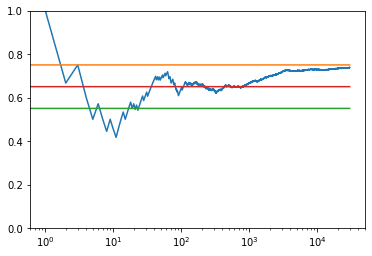

In [563]:
mab.run_experiment('epsilon_greedy', eps=0.1)
mab.plot_ctr()

[[28488 21348]
 [  434   242]
 [ 1082   690]]
ads A served: 28488


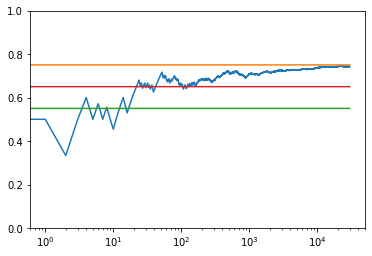

In [564]:
mab.run_experiment('ucb1')
mab.plot_ctr()

[[29731 22313]
 [   78    44]
 [  195   123]]
ads A served: 29731


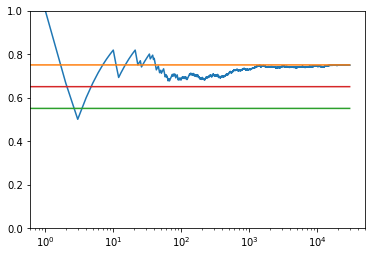

In [569]:
mab.run_experiment('thompson')
mab.plot_ctr()

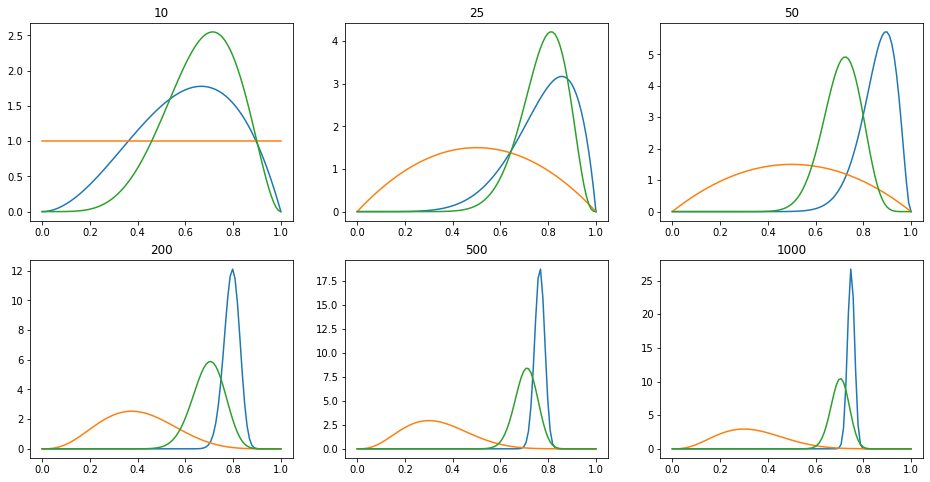

In [444]:
mab.plot_thompson_snapshots()

___

## Appendix

### Examples of Beta Distribution

We want to measure the clickthrough rate of our website. The more data we have, the more confident we are of its value. In other words, the confidence interval narrows when the sample size increases.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

class Clickthrough:
    
    def __init__(self, true_ctr):
        '''
        init the ctr class true ctr
        and observations (total and actual ctr)
        '''
        self.true_ctr = true_ctr
        self.obs_visits = 0
        self.obs_clicks = 0
        self.obs_ctr = 0
        
        self.x = np.linspace(0, 1, 200)
        self.betas = {}
        
    def beta(self):
        '''
        saves the beta distribution of shape parameters
        self.obs_clicks and self.obs_visits
        '''
        y = beta.pdf(self.x, self.obs_clicks, self.obs_visits)
        self.betas[self.obs_visits] = [self.obs_ctr, y]

    def visit(self):
        '''
        simulates a visit that have a self.true_ctr likelihood
        of doing a ctr
        '''
        # random visit result
        self.obs_visits += 1
        visit_result = (np.random.random() < self.true_ctr)
        if visit_result:
            self.obs_clicks += 1

        # current observed ctr
        self.obs_ctr = self.obs_clicks / self.obs_visits
        
        # saves beta distribution
        if self.obs_visits in [0, 5, 10, 25, 50, 200, 500]:
            self.beta()
        
    def plot(self):
        '''
        show beta distributions
        '''

        # init plot fig
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        for (obs_visits, [obs_ctr, obs_beta]) in self.betas.items():
            ax.plot(self.x, obs_beta, label = '{} visits - obs_ctr: {:.2}'.format(obs_visits, obs_ctr))
            ax.legend()

        plt.show()

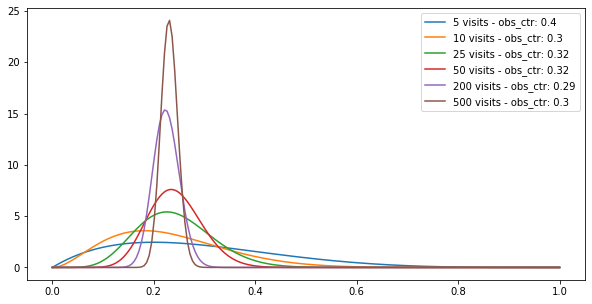

In [54]:
ctr = Clickthrough(0.3) 
for visits in range(501):
    ctr.visit()
    
ctr.plot()

### CLT Confidence Interval vs Beta Distribution

Let's consider a Bernoulli experiment of known probability of success.

At each step of the following experiment, we can display:
+ the sampling distribution of the sample probability (gaussian of known standard error)
+ the posterior beta distribution of the population probability based on the prior observations

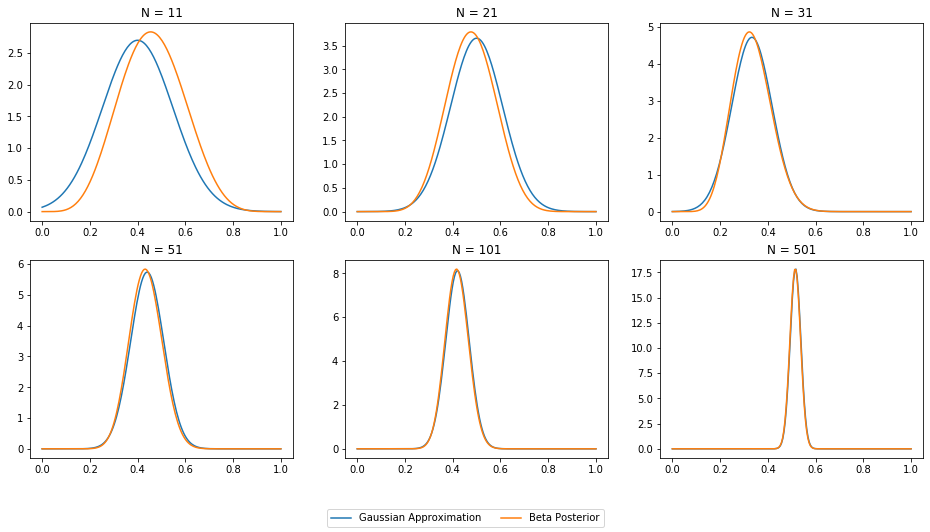

In [513]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, norm

# parameters
true_ctr = 0.5          # we assume a fair coin
a, b = 1, 1             # beta priors
T = 501                 # number of coin tosses
results = np.empty(T)   # results of each coin toss

# init plot fig
x = np.linspace(0, 1, 200)
plot_indices = (10, 20, 30, 50, 100, 500)
fig = plt.figure(figsize=(16,8))
plot_shape = [2, 3]
idx = 1

    
# trials
for i in range(T):
    
    # coin toss result
    result = 1 if np.random.random() < true_ctr else 0
    results[i] = result

    # update a and b
    a += result
    b += 1 - result

    if i in plot_indices:
        
        # add plot
        ax1 = fig.add_subplot(plot_shape[0], plot_shape[1], idx)
        
        # maximum likelihood estimate of ctr
        n = i + 1 # number of samples collected so far
        p = results[:i].mean()
        std = np.sqrt(p*(1-p)/n)

        # gaussian
        g = norm.pdf(x, loc=p, scale=std)
        ax1.plot(x, g, label='Gaussian Approximation')

        # beta
        posterior = beta.pdf(x, a=a, b=b)
        ax1.plot(x, posterior, label='Beta Posterior')
        ax1.set_title("N = %s" % n)
        
        idx +=1
        
        # get legend from the first subplot
        h, l = ax1.get_legend_handles_labels()

# apply the values to the graph legend
fig.legend(h, l, loc='lower center', ncol=3)

# show
plt.show()


### CTR Example

In [207]:
#chi-square example
import pandas as pd
import scipy.stats as stats 

csv_path = r'..\courses material\Bayesian Machine Learning\advertisement_clicks.csv'
ctr = pd.read_csv(csv_path, dtype={'advertisement_id': str, 'action': int})

# build df
df = ctr.groupby('advertisement_id').agg({'action': ['count', 'sum']})
df.columns = ['Total', 'Click']
df['No Click'] = df['Total'] - df['Click']
df = df.drop(columns = ['Total'])

display(df)

# we reject the null hypothesis of no impact: ad B is better than A
chi2, p, _, _ = stats.chi2_contingency(df)
print('Chi-Square test: {:.3} - p-value: {:.3}'.format(chi2, p)) 

,Click,No Click
advertisement_id,,
A,304,696
B,372,628


Chi-Square test: 10.0 - p-value: 0.00154
